In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
from math import exp
from matplotlib.pylab import rcParams

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbzz.root")
backgroundFile=TFile.Open("samples/sig_nonres_bbtt.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  75809
background events number before cut is:  217248


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(75809, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

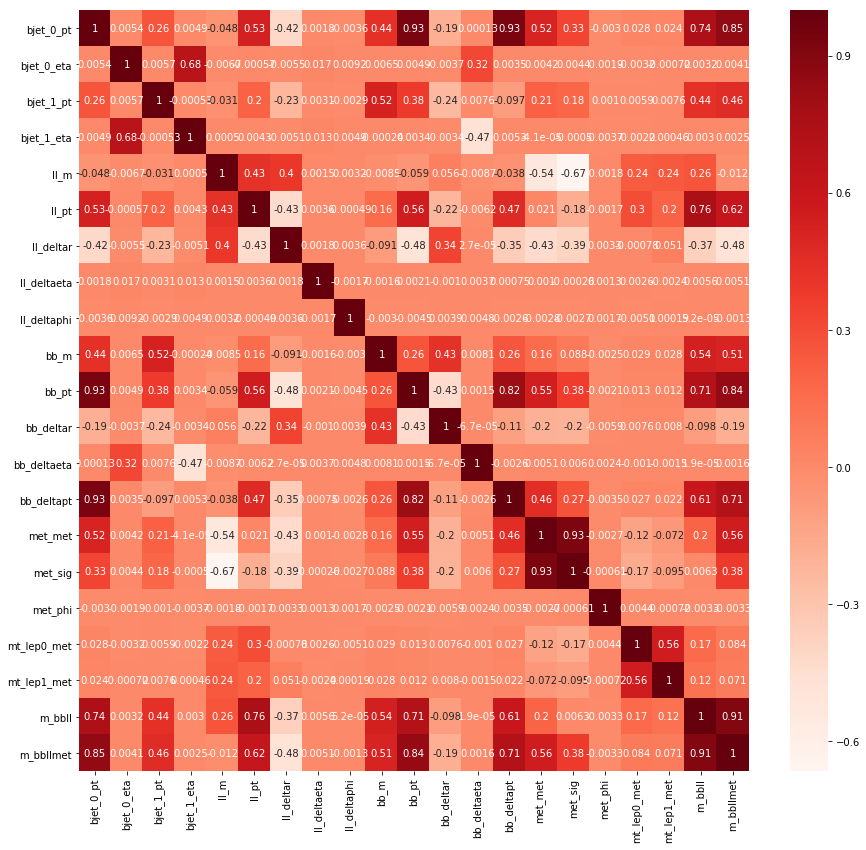

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

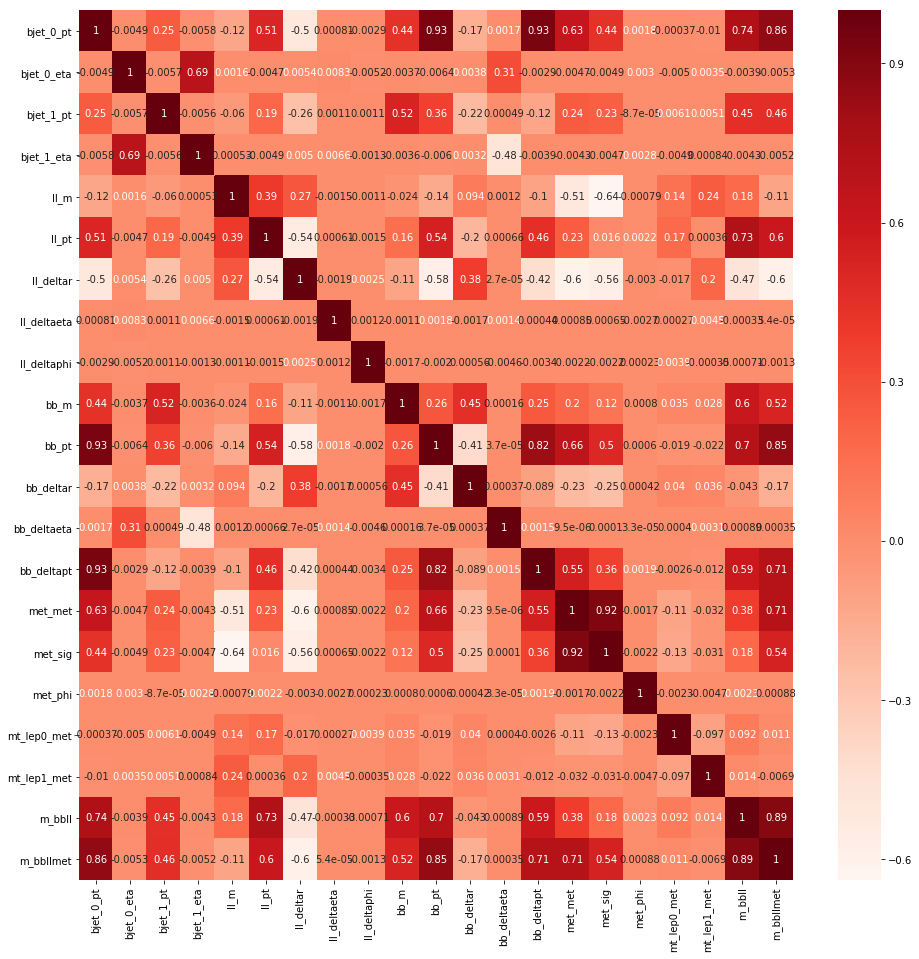

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 7.44818327e-07  1.06398070e+05 -8.51465642e-01 ...  1.67548516e+04
   4.26808188e+05  4.88755188e+05]
 [ 1.59458984e-07  2.06580719e+05 -1.27479148e+00 ...  5.15779141e+04
   7.98903688e+05  8.56081875e+05]
 [ 8.09472716e-07  1.32475984e+05  3.39121938e-01 ...  1.92662500e+04
   2.89801688e+05  4.88526250e+05]
 ...
 [ 1.65113239e-07  1.02363820e+05  8.04546416e-01 ...  4.17481328e+04
   8.63429250e+05  8.78042938e+05]
 [ 1.93601197e-07  3.54055469e+05 -2.08675280e-01 ...  2.02780938e+04
   7.03278562e+05  8.30059688e+05]
 [-9.16766753e-08  3.64696844e+05  4.29171950e-01 ...  2.43024629e+04
   5.73283750e+05  9.84956125e+05]]


In [10]:
print(signalArray[:,1])

[106398.0703125 206580.71875   132475.984375  ... 102363.8203125
 354055.46875   364696.84375  ]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

75809
217248


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  75809
background event number after cut is: 217248


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  68228
testing signal events number is:  7581
training background events number is:  195523
testing background events number is:  21725


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[ 0.00000000e+00  1.39161395e-07  2.67903344e+05 ...  1.32031602e+04
   9.43254438e+05  1.33605112e+06]
 [ 0.00000000e+00  1.10168760e-05  1.20924898e+05 ...  1.73660098e+04
   2.95004719e+05  4.09224625e+05]
 [ 0.00000000e+00 -1.21120882e-06  1.52380891e+05 ...  2.62457949e+04
   3.75647688e+05  6.92034938e+05]
 ...
 [ 0.00000000e+00 -9.47380129e-06  6.27549258e+04 ...  9.66342285e+03
   1.62068922e+05  2.97108219e+05]
 [ 0.00000000e+00  1.52831772e-05  1.77339031e+05 ...  5.27976250e+04
   4.75164688e+05  5.11365375e+05]
 [ 0.00000000e+00  1.65528623e-06  2.39564734e+05 ...  3.73748608e+03
   4.83871188e+05  1.09625988e+06]]
0.04391858496402934


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(263751, 21) dtype=float32>

Signal and background training sets should have same yield in training

(263751,)
(263751,)


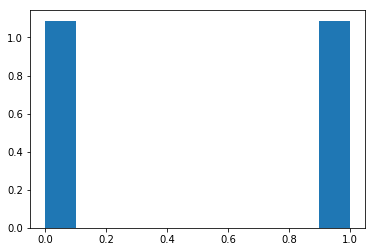

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["binary_accuracy"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalNN=model.predict(signalSample[:,1:])
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample)

In [ ]:
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_4lNN.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalArray[:,1:])
backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
cuda.select_device(0)
cuda.close()

In [18]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 5, 'eta': 1.0, 'silent': 0, 'objective': 'reg:squarederror'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_exact'
param['grow_policy'] = 'lossguide'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [19]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.701256	train-auc:0.705983
[1]	eval-auc:0.804397	train-auc:0.808478
[2]	eval-auc:0.800931	train-auc:0.809772
[3]	eval-auc:0.810315	train-auc:0.81642
[4]	eval-auc:0.818555	train-auc:0.825046
[5]	eval-auc:0.83518	train-auc:0.84205
[6]	eval-auc:0.837216	train-auc:0.844925
[7]	eval-auc:0.837116	train-auc:0.845799
[8]	eval-auc:0.839062	train-auc:0.848041
[9]	eval-auc:0.846316	train-auc:0.85502
[10]	eval-auc:0.848228	train-auc:0.857608
[11]	eval-auc:0.850862	train-auc:0.859972
[12]	eval-auc:0.85283	train-auc:0.861923
[13]	eval-auc:0.858894	train-auc:0.866457
[14]	eval-auc:0.860465	train-auc:0.867469
[15]	eval-auc:0.861197	train-auc:0.868225
[16]	eval-auc:0.862845	train-auc:0.869955
[17]	eval-auc:0.863426	train-auc:0.870808
[18]	eval-auc:0.866065	train-auc:0.87313
[19]	eval-auc:0.867383	train-auc:0.873925
[20]	eval-auc:0.868316	train-auc:0.874734
[21]	eval-auc:0.869433	train-auc:0.87546
[22]	eval-auc:0.870217	train-auc:0.876232
[23]	eval-auc:0.871038	train-auc:0.877351
[24]	eval

[194]	eval-auc:0.890481	train-auc:0.903481
[195]	eval-auc:0.890428	train-auc:0.903594
[196]	eval-auc:0.8905	train-auc:0.903669
[197]	eval-auc:0.890544	train-auc:0.903675
[198]	eval-auc:0.890475	train-auc:0.903688
[199]	eval-auc:0.890533	train-auc:0.903729
[200]	eval-auc:0.890513	train-auc:0.903839
[201]	eval-auc:0.890512	train-auc:0.903851
[202]	eval-auc:0.890505	train-auc:0.90387
[203]	eval-auc:0.890509	train-auc:0.903955
[204]	eval-auc:0.890452	train-auc:0.904018
[205]	eval-auc:0.890493	train-auc:0.904055
[206]	eval-auc:0.890512	train-auc:0.904133
[207]	eval-auc:0.890576	train-auc:0.904203
[208]	eval-auc:0.890613	train-auc:0.90421
[209]	eval-auc:0.89052	train-auc:0.904272
[210]	eval-auc:0.890557	train-auc:0.904385
[211]	eval-auc:0.890543	train-auc:0.904433
[212]	eval-auc:0.890582	train-auc:0.904448
[213]	eval-auc:0.890644	train-auc:0.904488
[214]	eval-auc:0.890674	train-auc:0.904547
[215]	eval-auc:0.890532	train-auc:0.904537
[216]	eval-auc:0.890665	train-auc:0.904591
[217]	eval-auc:0

[386]	eval-auc:0.893359	train-auc:0.911968
[387]	eval-auc:0.893312	train-auc:0.912018
[388]	eval-auc:0.893394	train-auc:0.91206
[389]	eval-auc:0.893457	train-auc:0.912076
[390]	eval-auc:0.893418	train-auc:0.912112
[391]	eval-auc:0.893474	train-auc:0.912124
[392]	eval-auc:0.893429	train-auc:0.91215
[393]	eval-auc:0.89351	train-auc:0.912168
[394]	eval-auc:0.893454	train-auc:0.912205
[395]	eval-auc:0.893551	train-auc:0.912277
[396]	eval-auc:0.893599	train-auc:0.912278
[397]	eval-auc:0.893573	train-auc:0.91233
[398]	eval-auc:0.893536	train-auc:0.912378
[399]	eval-auc:0.893478	train-auc:0.912408
[400]	eval-auc:0.893612	train-auc:0.912457
[401]	eval-auc:0.893522	train-auc:0.912475
[402]	eval-auc:0.893632	train-auc:0.912516
[403]	eval-auc:0.893671	train-auc:0.912535
[404]	eval-auc:0.893616	train-auc:0.912566
[405]	eval-auc:0.893652	train-auc:0.912586
[406]	eval-auc:0.89363	train-auc:0.912607
[407]	eval-auc:0.89368	train-auc:0.912616
[408]	eval-auc:0.893649	train-auc:0.912635
[409]	eval-auc:0.

[578]	eval-auc:0.893547	train-auc:0.919382
[579]	eval-auc:0.893428	train-auc:0.919425
[580]	eval-auc:0.893543	train-auc:0.919494
[581]	eval-auc:0.893604	train-auc:0.919522
[582]	eval-auc:0.893502	train-auc:0.91954
[583]	eval-auc:0.893413	train-auc:0.919578
[584]	eval-auc:0.893415	train-auc:0.919627
[585]	eval-auc:0.893438	train-auc:0.91965
[586]	eval-auc:0.893294	train-auc:0.919662
[587]	eval-auc:0.893379	train-auc:0.919704
[588]	eval-auc:0.893388	train-auc:0.919703
[589]	eval-auc:0.893379	train-auc:0.919752
[590]	eval-auc:0.893267	train-auc:0.919802
[591]	eval-auc:0.893346	train-auc:0.919872
[592]	eval-auc:0.893351	train-auc:0.919825
[593]	eval-auc:0.893356	train-auc:0.919855
[594]	eval-auc:0.893376	train-auc:0.919867
[595]	eval-auc:0.893398	train-auc:0.919917
[596]	eval-auc:0.893378	train-auc:0.919948
[597]	eval-auc:0.893358	train-auc:0.919993
[598]	eval-auc:0.893366	train-auc:0.920056
[599]	eval-auc:0.893359	train-auc:0.920073
[600]	eval-auc:0.893349	train-auc:0.920106
[601]	eval-au

[770]	eval-auc:0.893669	train-auc:0.924292
[771]	eval-auc:0.89359	train-auc:0.924299
[772]	eval-auc:0.893659	train-auc:0.924316
[773]	eval-auc:0.893573	train-auc:0.924322
[774]	eval-auc:0.893629	train-auc:0.924341
[775]	eval-auc:0.89357	train-auc:0.924346
[776]	eval-auc:0.893633	train-auc:0.924362
[777]	eval-auc:0.893576	train-auc:0.924372
[778]	eval-auc:0.893597	train-auc:0.924387
[779]	eval-auc:0.893579	train-auc:0.924388
[780]	eval-auc:0.893634	train-auc:0.924399
[781]	eval-auc:0.893583	train-auc:0.924406
[782]	eval-auc:0.893636	train-auc:0.92443
[783]	eval-auc:0.893602	train-auc:0.924435
[784]	eval-auc:0.893671	train-auc:0.924451
[785]	eval-auc:0.893616	train-auc:0.924457
[786]	eval-auc:0.893671	train-auc:0.924472
[787]	eval-auc:0.893613	train-auc:0.924482
[788]	eval-auc:0.893667	train-auc:0.924488
[789]	eval-auc:0.893623	train-auc:0.924495
[790]	eval-auc:0.893675	train-auc:0.924517
[791]	eval-auc:0.893616	train-auc:0.924527
[792]	eval-auc:0.893686	train-auc:0.924541
[793]	eval-auc

[962]	eval-auc:0.893389	train-auc:0.927473
[963]	eval-auc:0.893417	train-auc:0.927499
[964]	eval-auc:0.893475	train-auc:0.927524
[965]	eval-auc:0.893448	train-auc:0.927555
[966]	eval-auc:0.893444	train-auc:0.927581
[967]	eval-auc:0.893453	train-auc:0.927584
[968]	eval-auc:0.893403	train-auc:0.927578
[969]	eval-auc:0.893434	train-auc:0.927626
[970]	eval-auc:0.893424	train-auc:0.927639
[971]	eval-auc:0.893408	train-auc:0.927656
[972]	eval-auc:0.893457	train-auc:0.927668
[973]	eval-auc:0.893434	train-auc:0.927693
[974]	eval-auc:0.893423	train-auc:0.927716
[975]	eval-auc:0.893358	train-auc:0.927733
[976]	eval-auc:0.893328	train-auc:0.927753
[977]	eval-auc:0.893323	train-auc:0.927773
[978]	eval-auc:0.893315	train-auc:0.927772
[979]	eval-auc:0.89336	train-auc:0.927788
[980]	eval-auc:0.893312	train-auc:0.927794
[981]	eval-auc:0.893346	train-auc:0.927813
[982]	eval-auc:0.89327	train-auc:0.927815
[983]	eval-auc:0.893322	train-auc:0.927835
[984]	eval-auc:0.893264	train-auc:0.927844
[985]	eval-au

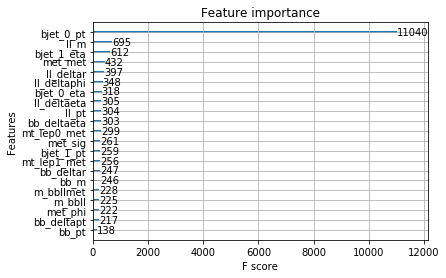

In [20]:
xgb.plot_importance(GBDT)

(array([1.0000e+00, 5.0000e+01, 3.2300e+02, 2.0950e+03, 1.2977e+04,
        4.2229e+04, 5.2962e+04, 4.3048e+04, 3.1968e+04, 1.5973e+04,
        6.4480e+03, 4.3420e+03, 3.3710e+03, 1.2460e+03, 1.9900e+02,
        1.3000e+01, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-0.5602405 , -0.4430793 , -0.32591808, -0.20875688, -0.09159567,
         0.02556553,  0.14272675,  0.25988796,  0.37704915,  0.49421036,
         0.6113716 ,  0.7285328 ,  0.845694  ,  0.9628552 ,  1.0800164 ,
         1.1971776 ,  1.3143388 ,  1.4315001 ,  1.5486612 ,  1.6658225 ,
         1.7829837 ], dtype=float32),
 <a list of 20 Patch objects>)

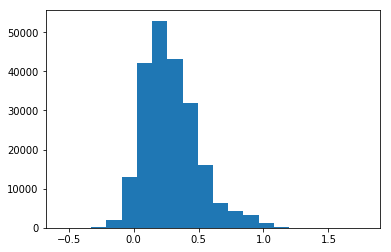

In [21]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([1.0000e+00, 3.0000e+00, 2.0000e+01, 7.7000e+01, 2.8100e+02,
        8.5900e+02, 2.1030e+03, 3.3620e+03, 4.3220e+03, 5.4080e+03,
        6.2590e+03, 6.9290e+03, 8.6910e+03, 1.2430e+04, 1.3642e+04,
        8.1570e+03, 2.6530e+03, 5.4300e+02, 6.5000e+01, 4.0000e+00]),
 array([-0.53571844, -0.4342881 , -0.3328578 , -0.23142748, -0.12999716,
        -0.02856684,  0.07286348,  0.1742938 ,  0.2757241 ,  0.37715444,
         0.47858477,  0.58001506,  0.6814454 ,  0.7828757 ,  0.8843061 ,
         0.98573637,  1.0871667 ,  1.188597  ,  1.2900274 ,  1.3914577 ,
         1.492888  ], dtype=float32),
 <a list of 20 Patch objects>)

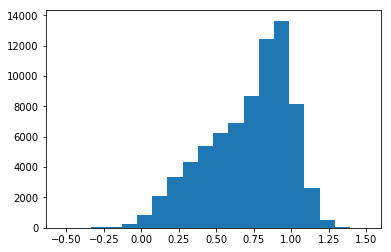

In [22]:
#logSigScore=exp(SignalScore)
plt.hist(SignalScore,bins=20)

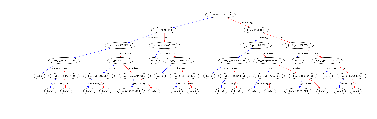

In [23]:
plot_tree(GBDT, num_trees=4)

(array([2.0000e+00, 5.0000e+01, 3.2300e+02, 2.0200e+03, 1.2194e+04,
        3.9542e+04, 5.0919e+04, 4.3172e+04, 3.4589e+04, 2.0935e+04,
        1.3555e+04, 1.4780e+04, 1.7604e+04, 1.0636e+04, 2.9380e+03,
        4.5300e+02, 3.4000e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-0.56024146, -0.4430802 , -0.3259189 , -0.20875765, -0.09159639,
         0.02556488,  0.14272615,  0.25988743,  0.37704867,  0.49420995,
         0.6113712 ,  0.7285325 ,  0.84569377,  0.96285504,  1.0800163 ,
         1.1971775 ,  1.3143388 ,  1.4315001 ,  1.5486614 ,  1.6658226 ,
         1.7829839 ], dtype=float32),
 <a list of 20 Patch objects>)

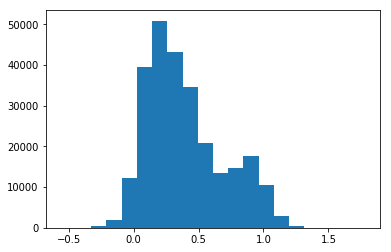

In [24]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [25]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

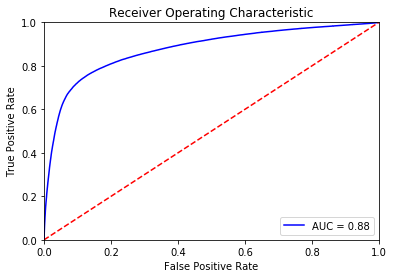

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'NNTrainScore' is not defined

In [28]:
pickle.dump(GBDT, open("GBDT_HHttzz.pickle.dat", "wb"))

In [29]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

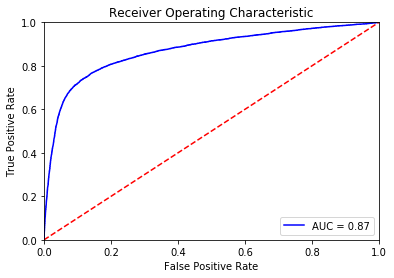

In [30]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

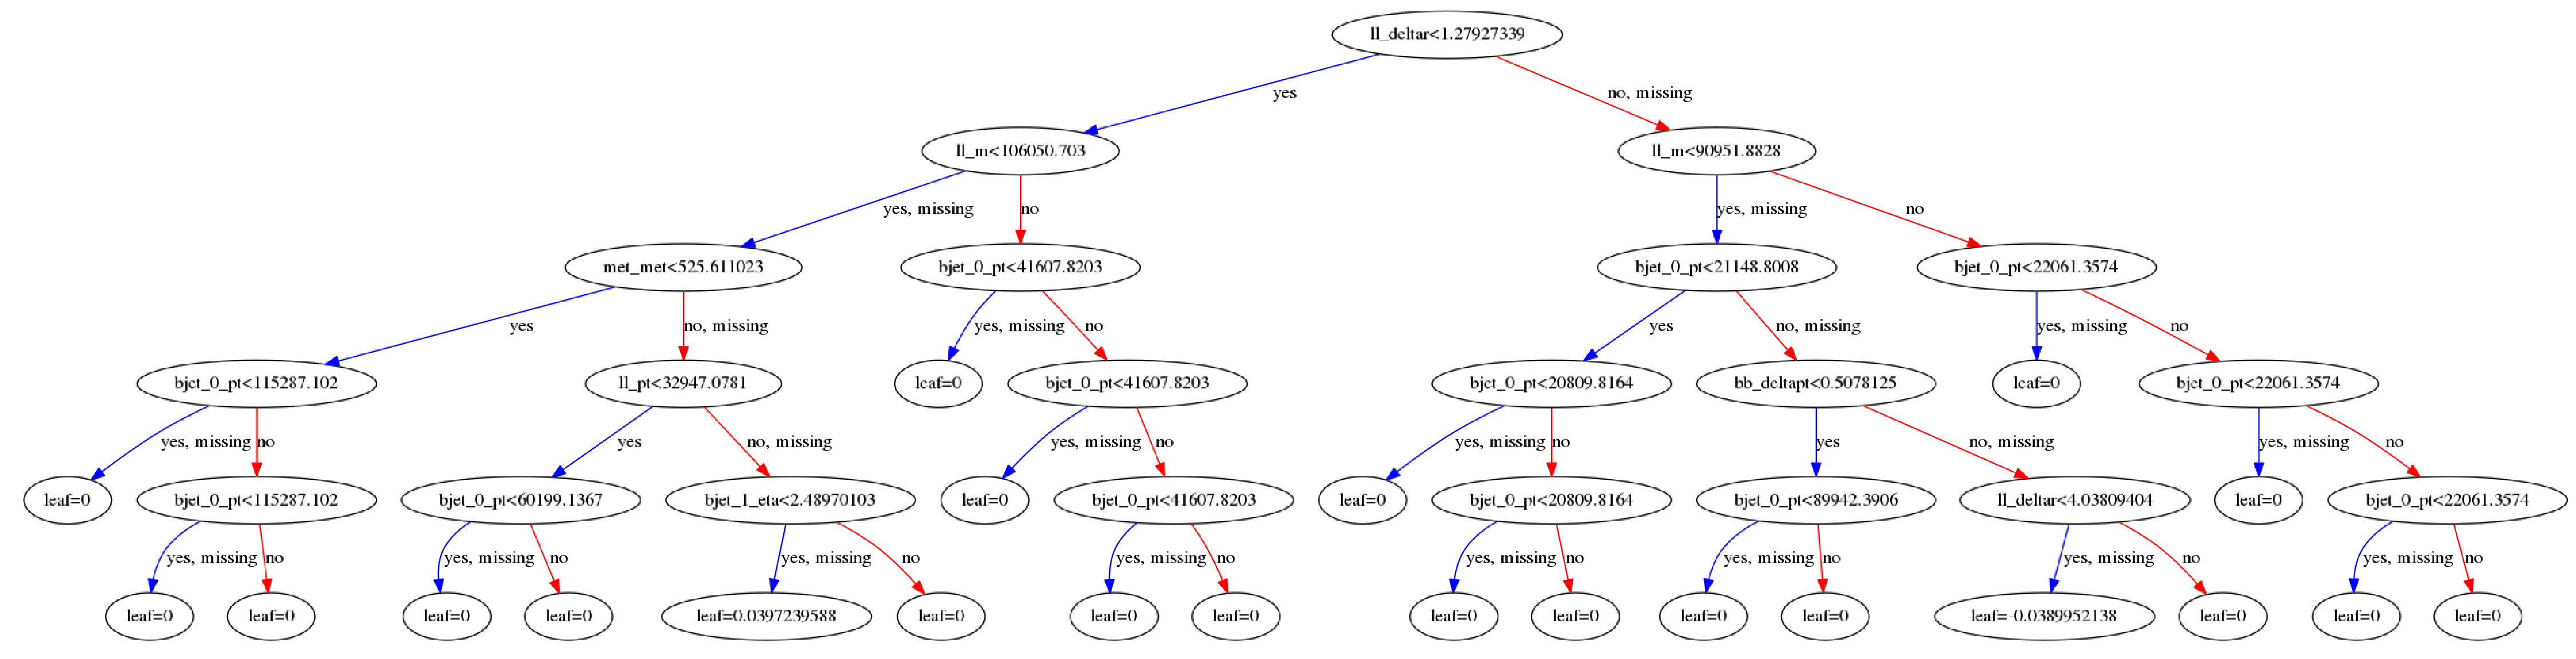

In [31]:
rcParams['figure.figsize'] = 80,50
plot_tree(GBDT, num_trees=4)